In [1]:
import os
import math
import imblearn
import logging
import warnings
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score , accuracy_score , precision_score, recall_score ,confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import genfromtxt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTEENN
%matplotlib inline




from warnings import simplefilter

In [2]:
import tensorflow as tf

# Check if TensorFlow detects a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2025-04-10 01:13:16.237497: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 01:13:16.257170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 01:13:16.272136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 01:13:16.275908: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 01:13:16.287243: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  0


I0000 00:00:1744227797.540777   90380 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-10 01:13:17.575512: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
df=pd.read_csv('parkinsons data.csv')


In [4]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [5]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [7]:
df=df.drop('name',axis=1)

array([[<Axes: title={'center': 'MDVP:Fo(Hz)'}>,
        <Axes: title={'center': 'MDVP:Fhi(Hz)'}>,
        <Axes: title={'center': 'MDVP:Flo(Hz)'}>,
        <Axes: title={'center': 'MDVP:Jitter(%)'}>,
        <Axes: title={'center': 'MDVP:Jitter(Abs)'}>],
       [<Axes: title={'center': 'MDVP:RAP'}>,
        <Axes: title={'center': 'MDVP:PPQ'}>,
        <Axes: title={'center': 'Jitter:DDP'}>,
        <Axes: title={'center': 'MDVP:Shimmer'}>,
        <Axes: title={'center': 'MDVP:Shimmer(dB)'}>],
       [<Axes: title={'center': 'Shimmer:APQ3'}>,
        <Axes: title={'center': 'Shimmer:APQ5'}>,
        <Axes: title={'center': 'MDVP:APQ'}>,
        <Axes: title={'center': 'Shimmer:DDA'}>,
        <Axes: title={'center': 'NHR'}>],
       [<Axes: title={'center': 'HNR'}>,
        <Axes: title={'center': 'status'}>,
        <Axes: title={'center': 'RPDE'}>,
        <Axes: title={'center': 'DFA'}>,
        <Axes: title={'center': 'spread1'}>],
       [<Axes: title={'center': 'spread2'}>,
   

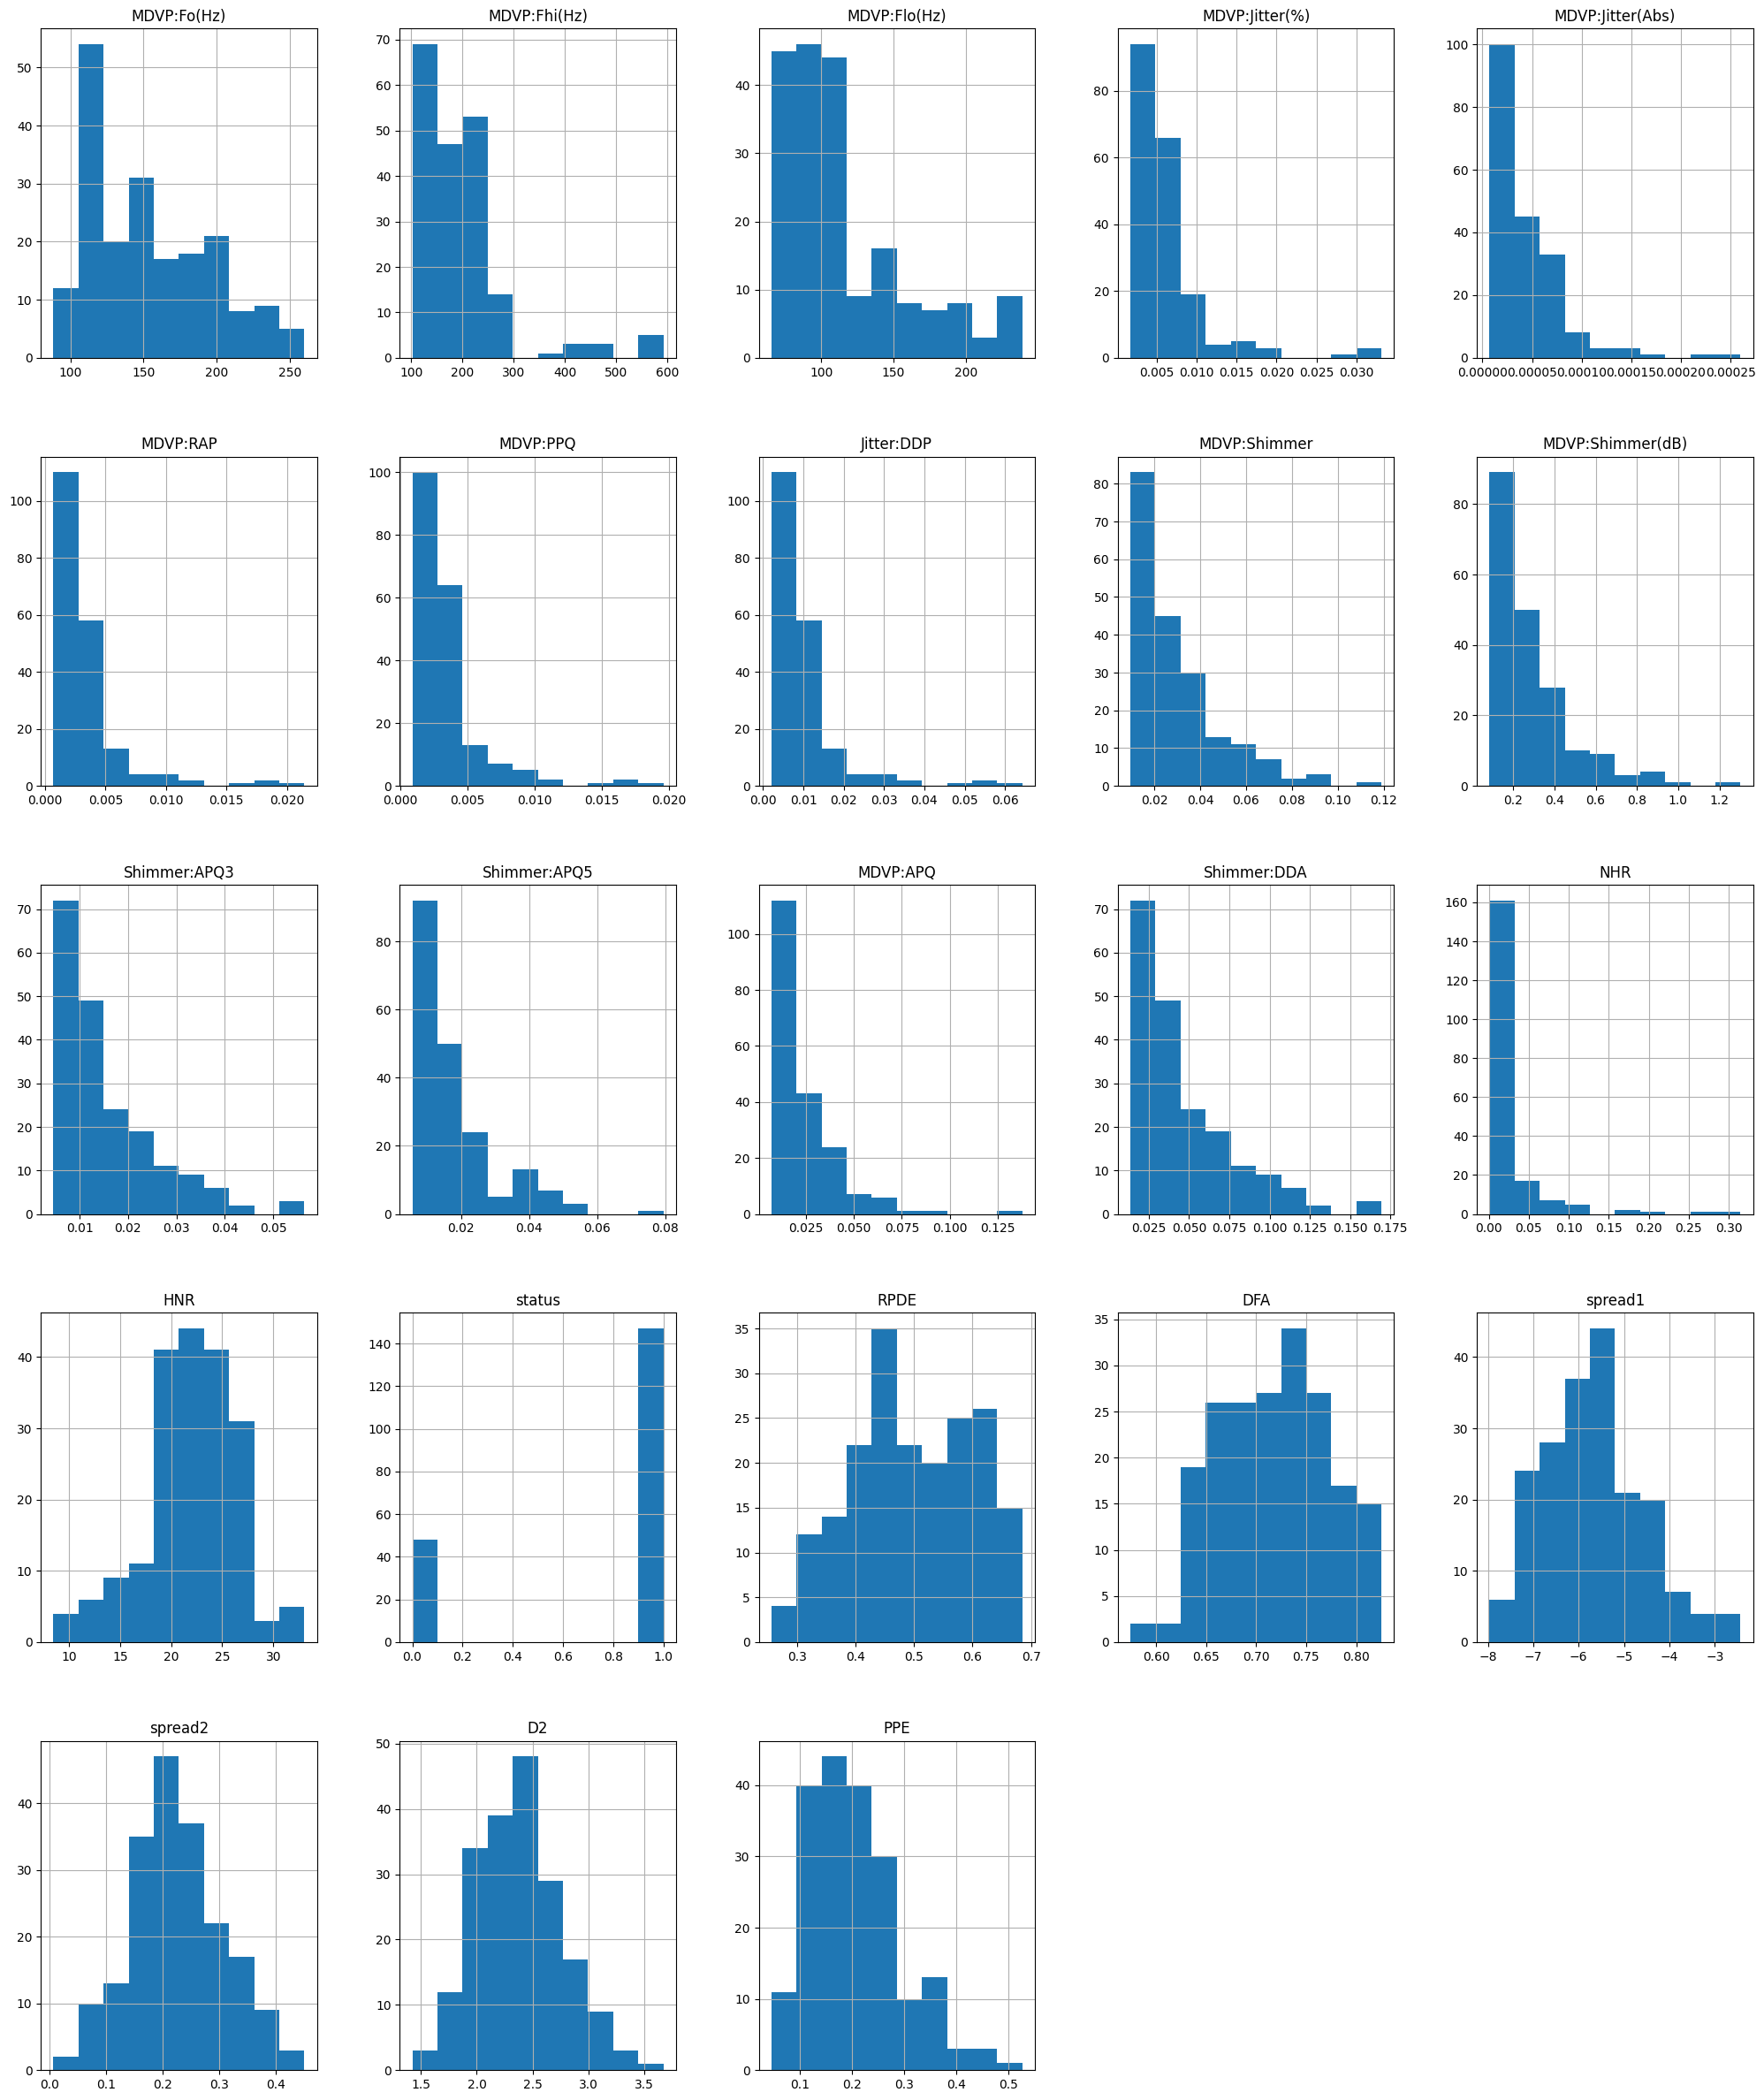

In [8]:
df.hist(figsize=(25,30))

In [9]:
print(df.columns)


Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')


In [10]:
print(df.isnull().sum())


MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


In [11]:
features = df.drop(columns=['status'])
target = df['status']

In [12]:
target

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_normalized = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)


In [14]:
df_normalized = features_normalized.copy()
df_normalized['status'] = target

In [15]:
df_normalized

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,0.184308,0.112592,0.054815,0.195680,0.249012,0.145472,0.247588,0.145288,0.312215,0.280197,...,0.332584,0.068307,0.511745,0.369155,0.960148,0.569875,0.585765,0.390661,0.497310,1
1,0.198327,0.094930,0.278323,0.254130,0.288538,0.191233,0.323687,0.191042,0.472887,0.444536,...,0.516048,0.059331,0.432577,0.470830,0.977024,0.703277,0.741337,0.473145,0.671326,1
2,0.165039,0.059128,0.265288,0.280178,0.328063,0.229287,0.369239,0.229411,0.390634,0.326212,...,0.443317,0.039596,0.496220,0.404416,1.000000,0.636745,0.686371,0.408819,0.596682,1
3,0.165004,0.072927,0.264200,0.263342,0.328063,0.209056,0.324759,0.208862,0.414278,0.354971,...,0.475478,0.040997,0.495936,0.416255,0.975885,0.695627,0.738089,0.436977,0.671949,1
4,0.161150,0.080909,0.260107,0.354511,0.407115,0.282755,0.437299,0.282870,0.499452,0.410025,...,0.584542,0.054174,0.455499,0.375159,0.992813,0.762472,0.513798,0.404336,0.757611,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,0.499820,0.262986,0.165722,0.092440,0.090909,0.093931,0.089496,0.094076,0.286014,0.262942,...,0.362306,0.085909,0.450134,0.447684,0.333127,0.257894,0.260408,0.549049,0.183318,0
191,0.705488,0.307974,0.138243,0.125794,0.090909,0.126686,0.107181,0.126826,0.164050,0.146261,...,0.221338,0.055543,0.435097,0.408567,0.434101,0.319956,0.276956,0.605474,0.257558,0
192,0.502730,0.281413,0.050727,0.378653,0.288538,0.267823,0.252947,0.267940,0.123608,0.140509,...,0.156631,0.338988,0.383728,0.352318,0.324299,0.212945,0.342577,0.558967,0.180580,0
193,0.642893,0.601807,0.054279,0.181703,0.130435,0.145472,0.159700,0.145288,0.122512,0.128184,...,0.155989,0.227838,0.429936,0.454176,0.277579,0.220650,0.452885,0.318222,0.163137,0


/tmp/ipykernel_90380/1328955033.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(parkinsons["MDVP:Fo(Hz)"], label="Parkinson's Patients", shade=True, color="red")
/tmp/ipykernel_90380/1328955033.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(healthy["MDVP:Fo(Hz)"], label="Healthy Individuals", shade=True, color="blue")


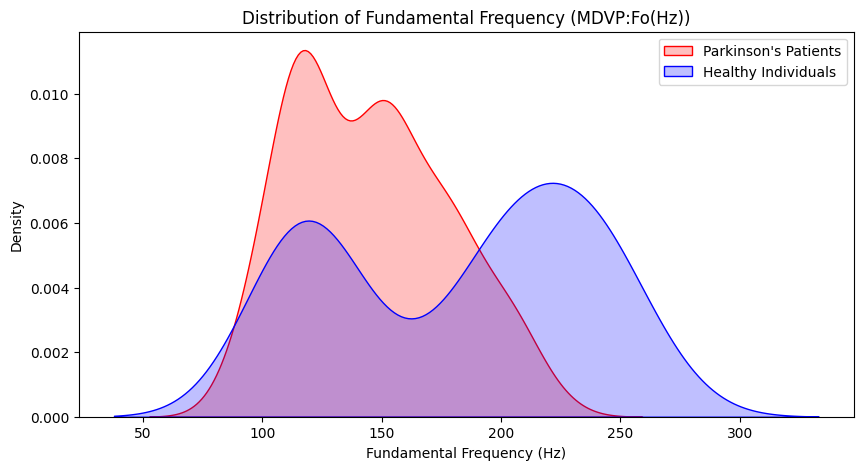

In [16]:
parkinsons = df[df["status"] == 1]
healthy = df[df["status"] == 0]

# Plot fundamental frequency distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(parkinsons["MDVP:Fo(Hz)"], label="Parkinson's Patients", shade=True, color="red")
sns.kdeplot(healthy["MDVP:Fo(Hz)"], label="Healthy Individuals", shade=True, color="blue")
plt.xlabel("Fundamental Frequency (Hz)")
plt.ylabel("Density")
plt.title("Distribution of Fundamental Frequency (MDVP:Fo(Hz))")
plt.legend()
plt.show()


In [17]:
# Compute mean and standard deviation
mean_healthy = healthy["MDVP:Fo(Hz)"].mean()
std_healthy = healthy["MDVP:Fo(Hz)"].std()
mean_parkinsons = parkinsons["MDVP:Fo(Hz)"].mean()
std_parkinsons = parkinsons["MDVP:Fo(Hz)"].std()

print(f"Healthy Individuals - Mean: {mean_healthy:.2f}, Std: {std_healthy:.2f}")
print(f"Parkinson's Patients - Mean: {mean_parkinsons:.2f}, Std: {std_parkinsons:.2f}")


Healthy Individuals - Mean: 181.94, Std: 52.73
Parkinson's Patients - Mean: 145.18, Std: 32.35


In [18]:
a=10

/tmp/ipykernel_90380/3469513068.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(parkinsons["MDVP:Fhi(Hz)"], label="Parkinson's Patients", shade=True, color="red")
/tmp/ipykernel_90380/3469513068.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(healthy["MDVP:Fhi(Hz)"], label="Healthy Individuals", shade=True, color="blue")


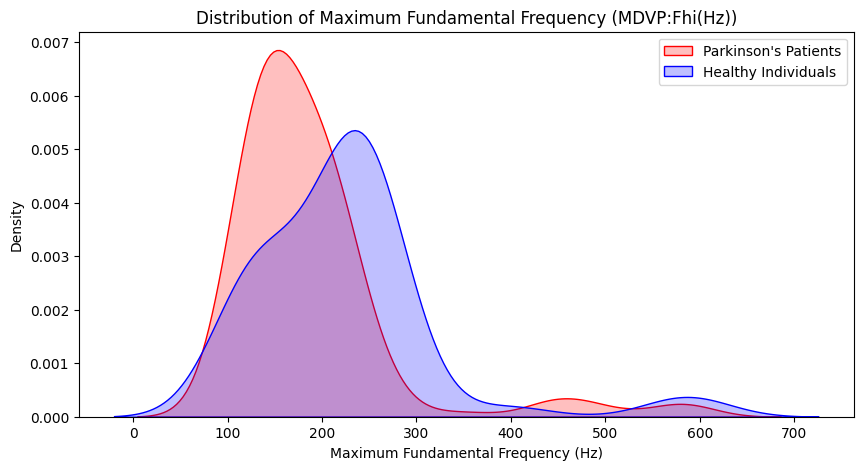

In [19]:
parkinsons = df[df["status"] == 1]
healthy = df[df["status"] == 0]

# Plot maximum fundamental frequency distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(parkinsons["MDVP:Fhi(Hz)"], label="Parkinson's Patients", shade=True, color="red")
sns.kdeplot(healthy["MDVP:Fhi(Hz)"], label="Healthy Individuals", shade=True, color="blue")
plt.xlabel("Maximum Fundamental Frequency (Hz)")
plt.ylabel("Density")
plt.title("Distribution of Maximum Fundamental Frequency (MDVP:Fhi(Hz))")
plt.legend()
plt.show()

In [20]:
# Compute mean and standard deviation for MDVP:Fhi(Hz)
mean_healthy = healthy["MDVP:Fhi(Hz)"].mean()
std_healthy = healthy["MDVP:Fhi(Hz)"].std()
mean_parkinsons = parkinsons["MDVP:Fhi(Hz)"].mean()
std_parkinsons = parkinsons["MDVP:Fhi(Hz)"].std()

# Print the results
print(f"MDVP:Fhi(Hz)Healthy Individuals - Mean: {mean_healthy:.2f}, Std: {std_healthy:.2f}")
print(f"MDVP:Fhi(Hz)Parkinson's Patients - Mean: {mean_parkinsons:.2f}, Std: {std_parkinsons:.2f}")


MDVP:Fhi(Hz)Healthy Individuals - Mean: 223.64, Std: 96.73
MDVP:Fhi(Hz)Parkinson's Patients - Mean: 188.44, Std: 88.34


/tmp/ipykernel_90380/4284402592.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(parkinsons["MDVP:Flo(Hz)"], label="Parkinson's Patients", shade=True, color="red")
/tmp/ipykernel_90380/4284402592.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(healthy["MDVP:Flo(Hz)"], label="Healthy Individuals", shade=True, color="blue")


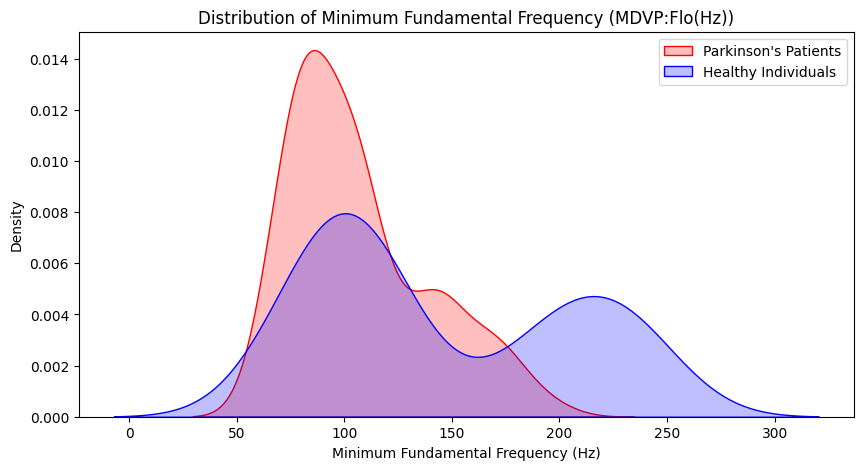

In [21]:
parkinsons = df[df["status"] == 1]
healthy = df[df["status"] == 0]

# Plot minimum fundamental frequency distributions
plt.figure(figsize=(10, 5))
sns.kdeplot(parkinsons["MDVP:Flo(Hz)"], label="Parkinson's Patients", shade=True, color="red")
sns.kdeplot(healthy["MDVP:Flo(Hz)"], label="Healthy Individuals", shade=True, color="blue")
plt.xlabel("Minimum Fundamental Frequency (Hz)")
plt.ylabel("Density")
plt.title("Distribution of Minimum Fundamental Frequency (MDVP:Flo(Hz))")
plt.legend()
plt.show()


In [22]:
mean_healthy = healthy["MDVP:Flo(Hz)"].mean()
std_healthy = healthy["MDVP:Flo(Hz)"].std()
mean_parkinsons = parkinsons["MDVP:Flo(Hz)"].mean()
std_parkinsons = parkinsons["MDVP:Flo(Hz)"].std()

# Print the results
print(f"Healthy Individuals - Mean: {mean_healthy:.2f}, Std: {std_healthy:.2f}")
print(f"Parkinson's Patients - Mean: {mean_parkinsons:.2f}, Std: {std_parkinsons:.2f}")

Healthy Individuals - Mean: 145.21, Std: 58.76
Parkinson's Patients - Mean: 106.89, Std: 32.27


/tmp/ipykernel_90380/1348463107.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(parkinsons[feature], label="Parkinson's Patients", shade=True, color="red")


Healthy Individuals:
       MDVP:Jitter(%)  MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP
mean        0.003866          0.000023  0.001925  0.002056    0.005776
std         0.002055          0.000015  0.001066  0.000943    0.003199

Parkinson's Patients:
       MDVP:Jitter(%)  MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP
mean        0.006989          0.000051  0.003757  0.003900    0.011273
std         0.005240          0.000037  0.003241  0.002998    0.009724


/tmp/ipykernel_90380/1348463107.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(healthy[feature], label="Healthy Individuals", shade=True, color="blue")
/tmp/ipykernel_90380/1348463107.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(parkinsons[feature], label="Parkinson's Patients", shade=True, color="red")
/tmp/ipykernel_90380/1348463107.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(healthy[feature], label="Healthy Individuals", shade=True, color="blue")
/tmp/ipykernel_90380/1348463107.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in

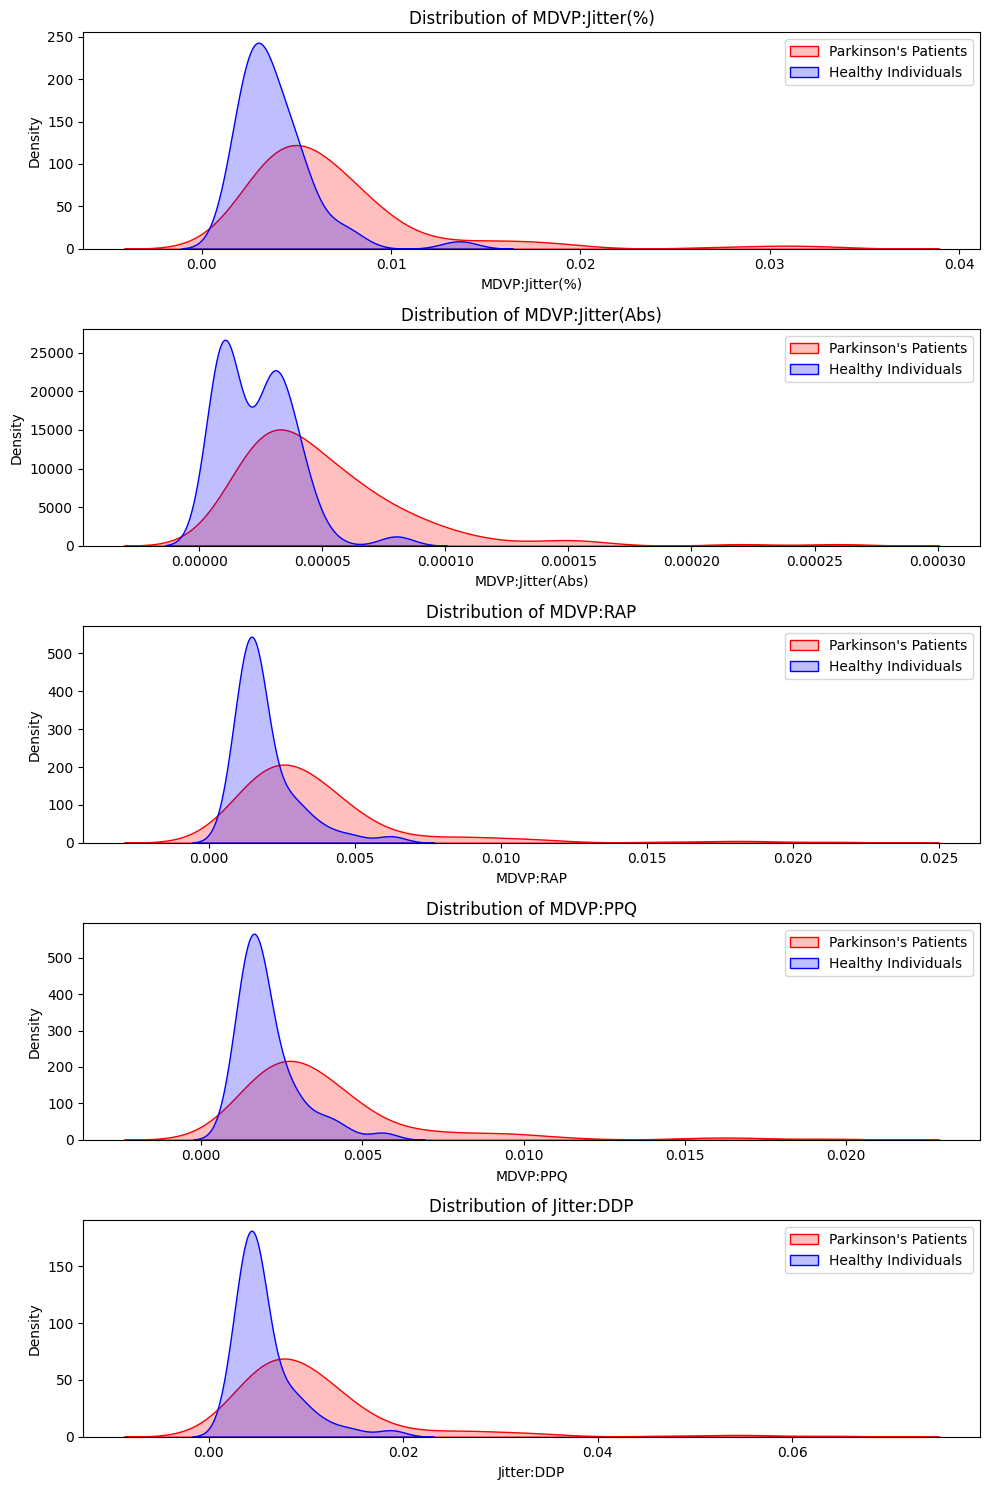

In [23]:
# List of selected features
features = ["MDVP:Jitter(%)", "MDVP:Jitter(Abs)", "MDVP:RAP", "MDVP:PPQ", "Jitter:DDP"]

# Compute statistics for healthy individuals
healthy_stats = healthy[features].agg(["mean", "std"])

# Compute statistics for Parkinson's patients
parkinsons_stats = parkinsons[features].agg(["mean", "std"])

# Display results
print("Healthy Individuals:\n", healthy_stats)
print("\nParkinson's Patients:\n", parkinsons_stats)
features = ["MDVP:Jitter(%)", "MDVP:Jitter(Abs)", "MDVP:RAP", "MDVP:PPQ", "Jitter:DDP"]

# Set figure size
plt.figure(figsize=(10, 15))

# Loop through features and create subplots (one per row)
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.kdeplot(parkinsons[feature], label="Parkinson's Patients", shade=True, color="red")
    sns.kdeplot(healthy[feature], label="Healthy Individuals", shade=True, color="blue")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(f"Distribution of {feature}")
    plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [24]:
# gnn
#ann
#hybrid

In [25]:
df

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [26]:
X = df.drop(columns=['status'])
y = df['status']


In [27]:
from tensorflow import keras
from tensorflow.keras import Layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [29]:
# Reshape: 6 time steps, 4 features each
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)



In [30]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a

        return tf.keras.backend.sum(output, axis=1)

In [31]:
time_steps = X_reshaped.shape[1]
n_features = X_reshaped.shape[2]
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense, BatchNormalization, Layer
inputs = Input(shape=(time_steps, n_features))


In [32]:
x = Conv1D(filters=64, kernel_size=1, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=1)(x)
x = Dropout(0.3)(x)


In [33]:
x = Bidirectional(LSTM(64, return_sequences=True))(x)

# Attention layer
x = Attention()(x)


In [34]:
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification


In [35]:
from tensorflow.keras.models import Model

In [36]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5424 - loss: 0.6918 - val_accuracy: 0.7949 - val_loss: 0.6561
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7536 - loss: 0.6114 - val_accuracy: 0.7949 - val_loss: 0.6166
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8889 - loss: 0.4936 - val_accuracy: 0.8205 - val_loss: 0.5679
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7956 - loss: 0.4410 - val_accuracy: 0.8205 - val_loss: 0.5188
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8261 - loss: 0.3698 - val_accuracy: 0.8205 - val_loss: 0.4700
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8601 - loss: 0.3118 - val_accuracy: 0.8205 - val_loss: 0.4257
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8698 - loss: 0.3004 - val_accuracy: 0.8205 - val_loss: 0.3915
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8854 - loss: 0.2482 - val_accuracy: 0.8205 - val_loss

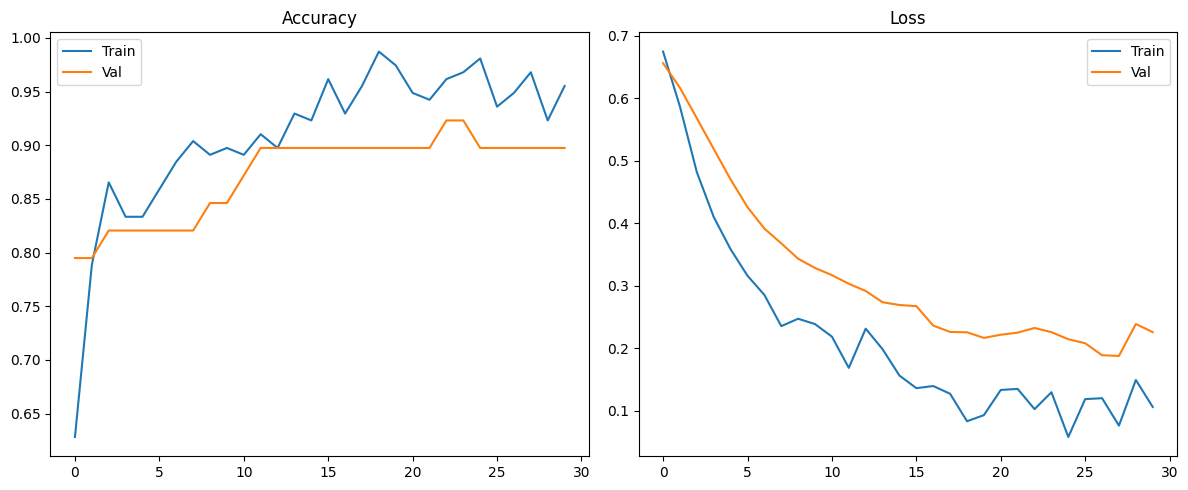

In [38]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [39]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9004 - loss: 0.2203 
Test Accuracy: 0.8974


In [40]:
import joblib

# Save it
joblib.dump(scaler, 'scaler_hybrid.pkl')


['scaler_hybrid.pkl']